## Egyptian hieroglyph classification

In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

import skimage
from skimage import io
from skimage.transform import resize

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import seaborn as sn

Article
 - https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9528382&tag=1

Dataset
 - https://drive.google.com/drive/folders/1bhnMJ8NbCa-qw53EKy-olZp3cJKZU_jc
 - https://drive.google.com/drive/folders/1X5HdFvgWJOVtA-GxBLr1K_0FHJS2RZcZ

In [2]:
train_dir = os.path.join(sys.path[0], 'train/')
test_dir = os.path.join(sys.path[0], 'test/')

In [3]:
def readHieroglyphData(data_dir):
    images = []
    targets = []
    for hier in os.listdir(data_dir):
        if not os.path.isdir(os.path.join(data_dir, hier)):
            continue
        for img in os.listdir(os.path.join(data_dir, hier)):
            targets.append(hier)
            images.append(np.asarray(io.imread(os.path.join(data_dir, hier, img))))
    return images, targets

In [4]:
def resizeImageData(data, image_size):
    resize_func = lambda img: resize(img, (image_size, image_size), anti_aliasing=True)
    resized_data = list(map(resize_func, data))
    return resized_data

In [5]:
images_train, targets_train = readHieroglyphData(train_dir)

In [6]:
images_test, targets_test = readHieroglyphData(test_dir)

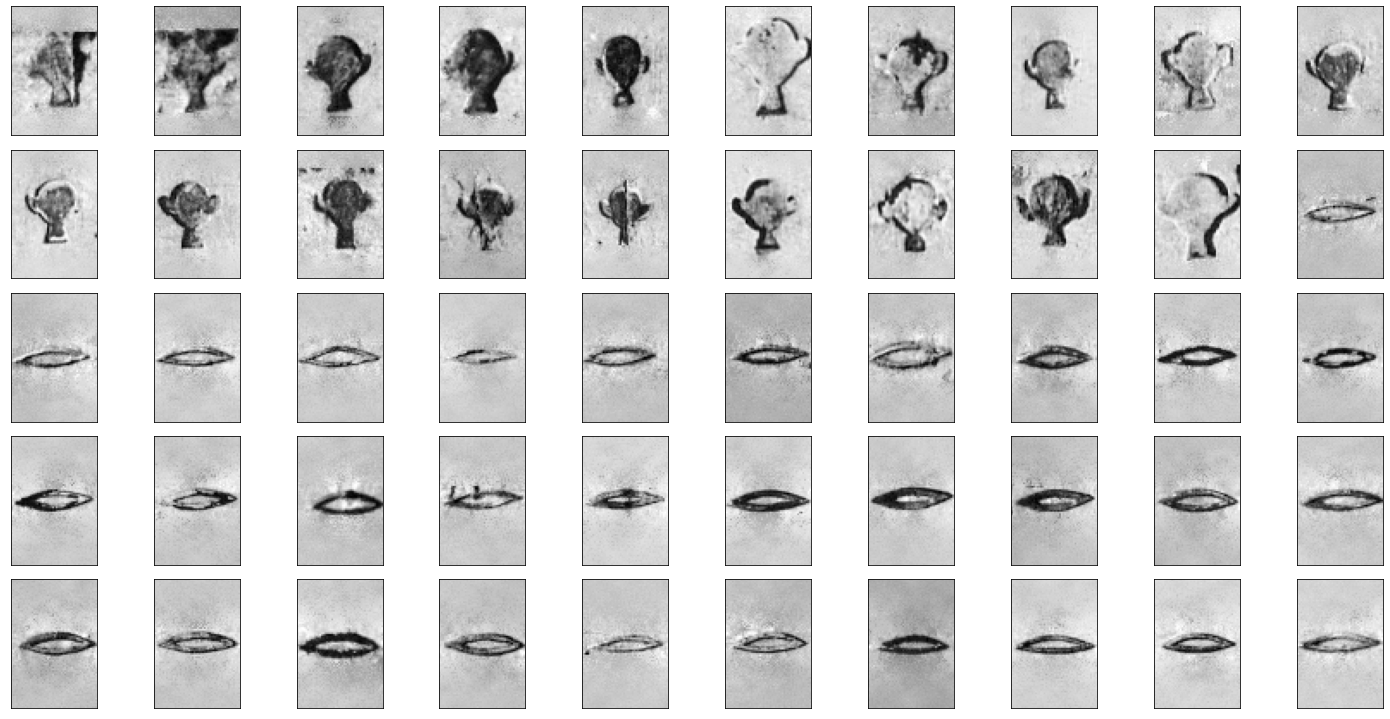

In [7]:
def overview(start, end, X):
    fig = plt.figure(figsize=(20,20))
    for i in range(start, end):
        ax = fig.add_subplot(10,10,i+1)
        ax.imshow(X[i], cmap='gray')
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
    plt.show()

overview(0, 50, images_train)

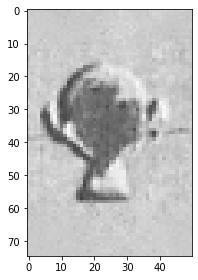

D2


In [8]:
io.imshow(images_test[0], cmap='gray')
io.show()
print(targets_test[0])

In [9]:
len(targets_train)

2467

In [10]:
len(targets_test)

635

In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(targets_train)
LabelEncoder()
print(list(le.classes_))

['D2', 'D21', 'D36', 'D4', 'D46', 'D58', 'E23', 'E34', 'F31', 'F35', 'G1', 'G17', 'G43', 'I10', 'I9', 'M17', 'M23', 'N35', 'O1', 'O34', 'O4', 'O49', 'Q1', 'Q3', 'R4', 'R8', 'S29', 'S34', 'U7', 'V13', 'V28', 'V30', 'V31', 'W11', 'W24', 'X1', 'X8', 'Y1', 'Y5', 'Z1']


In [12]:
labels_train = le.transform(targets_train)
labels_test = le.transform(targets_test)

In [13]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

num_labels = len(le.classes_)

# expand depth channel
x_train = np.expand_dims(images_train, -1) 
x_test = np.expand_dims(images_test, -1)

#resize images with padding
x_train = tf.image.resize_with_pad(
    x_train,
    100,
    100,
    method=tf.image.ResizeMethod.BILINEAR,
    antialias=False)

x_test = tf.image.resize_with_pad(
    x_test,
    100,
    100,
    method=tf.image.ResizeMethod.BILINEAR,
    antialias=False)

y_train = to_categorical(labels_train, num_labels)
y_test = to_categorical(labels_test, num_labels)

x_train.shape

TensorShape([2467, 100, 100, 1])

Resized images

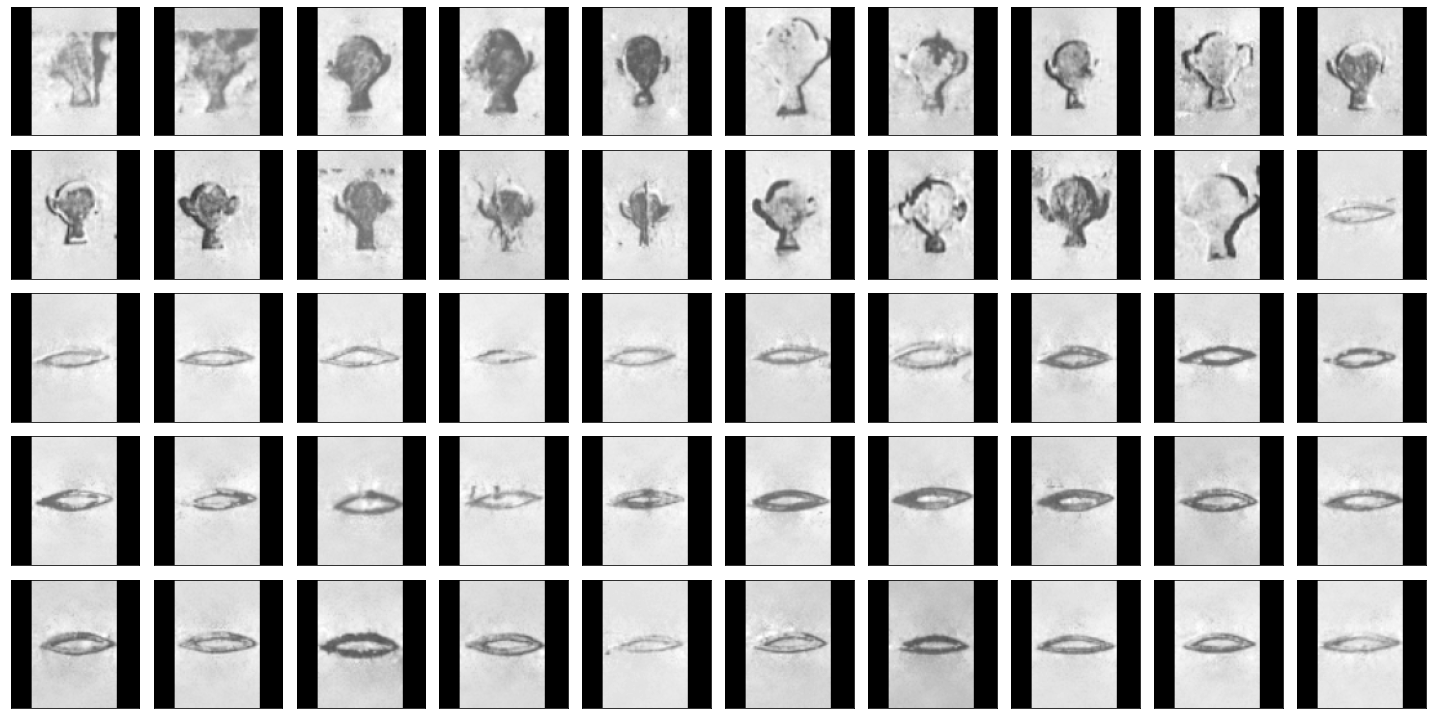

In [14]:
overview(0, 50, x_train)

### ResNet50 model

In [15]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, SeparableConv2D, GlobalAveragePooling2D

image_shape = (100, 100, 3)
base_model = ResNet50(include_top=False, input_shape=image_shape, pooling = 'avg', weights = 'imagenet')

modelResNet = Sequential()
modelResNet.add(base_model)

modelResNet.add(Dense(256, activation="relu"))
modelResNet.add(Dropout(0.3))
modelResNet.add(Dense(128, activation="relu"))
modelResNet.add(Dropout(0.3))

modelResNet.add(Dense(num_labels, activation = 'softmax'))

In [16]:
train_images_rgb = tf.image.grayscale_to_rgb(x_train)
test_images_rgb = tf.image.grayscale_to_rgb(x_test)

In [17]:
train_images_rgb_resnet = tf.keras.applications.resnet.preprocess_input(train_images_rgb)
test_images_rgb_resnet = tf.keras.applications.resnet.preprocess_input(test_images_rgb)

In [18]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)

In [19]:
modelResNet.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

train_history = modelResNet.fit(
    train_images_rgb_resnet, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(test_images_rgb_resnet, y_test))

Epoch 1/20
78/78 [==============================] - 35s 447ms/step - loss: 1.5510 - accuracy: 0.6234 - val_loss: 54.9607 - val_accuracy: 0.0394
Epoch 2/20
78/78 [==============================] - 30s 390ms/step - loss: 0.7123 - accuracy: 0.8269 - val_loss: 7.6521 - val_accuracy: 0.4646
Epoch 3/20
78/78 [==============================] - 30s 390ms/step - loss: 0.4392 - accuracy: 0.8885 - val_loss: 3.9446 - val_accuracy: 0.7559
Epoch 4/20
78/78 [==============================] - 31s 391ms/step - loss: 0.4329 - accuracy: 0.8987 - val_loss: 541.5342 - val_accuracy: 0.1811
Epoch 5/20
78/78 [==============================] - 31s 391ms/step - loss: 0.4178 - accuracy: 0.8987 - val_loss: 1.5911 - val_accuracy: 0.7102
Epoch 6/20
78/78 [==============================] - 30s 389ms/step - loss: 0.2431 - accuracy: 0.9392 - val_loss: 0.3445 - val_accuracy: 0.9276
Epoch 7/20
78/78 [==============================] - 30s 391ms/step - loss: 0.2388 - accuracy: 0.9481 - val_loss: 0.5444 - val_accuracy: 0.8

In [20]:
modelResNet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 40)                5160      
Total params: 24,150,312
Trainable params: 24,097,192
Non-trainable params: 53,120
_______________________________________

In [21]:
scores_resnet = modelResNet.evaluate(test_images_rgb_resnet, y_test)

print("Loss: " + str(scores_resnet[0]))
print("Accuracy: " + str(scores_resnet[1]))

20/20 [==============================] - 2s 97ms/step - loss: 0.4178 - accuracy: 0.9150
Loss: 0.41784340143203735
Accuracy: 0.9149606227874756


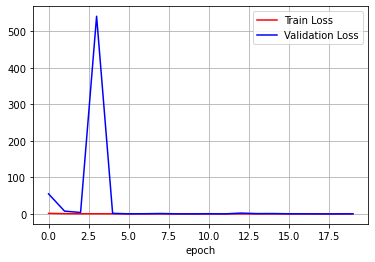

In [22]:
plt.plot(train_history.history['loss'], color='r', label='Train Loss')
plt.plot(train_history.history['val_loss'], color='b', label='Validation Loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()

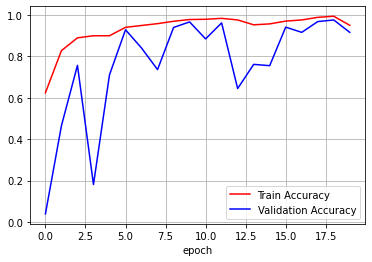

In [23]:
plt.plot(train_history.history['accuracy'], color='r', label='Train Accuracy')
plt.plot(train_history.history['val_accuracy'], color='b', label='Validation Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()

[Text(0.5, 123.0, 'Predicted label'), Text(168.0, 0.5, 'True label')]

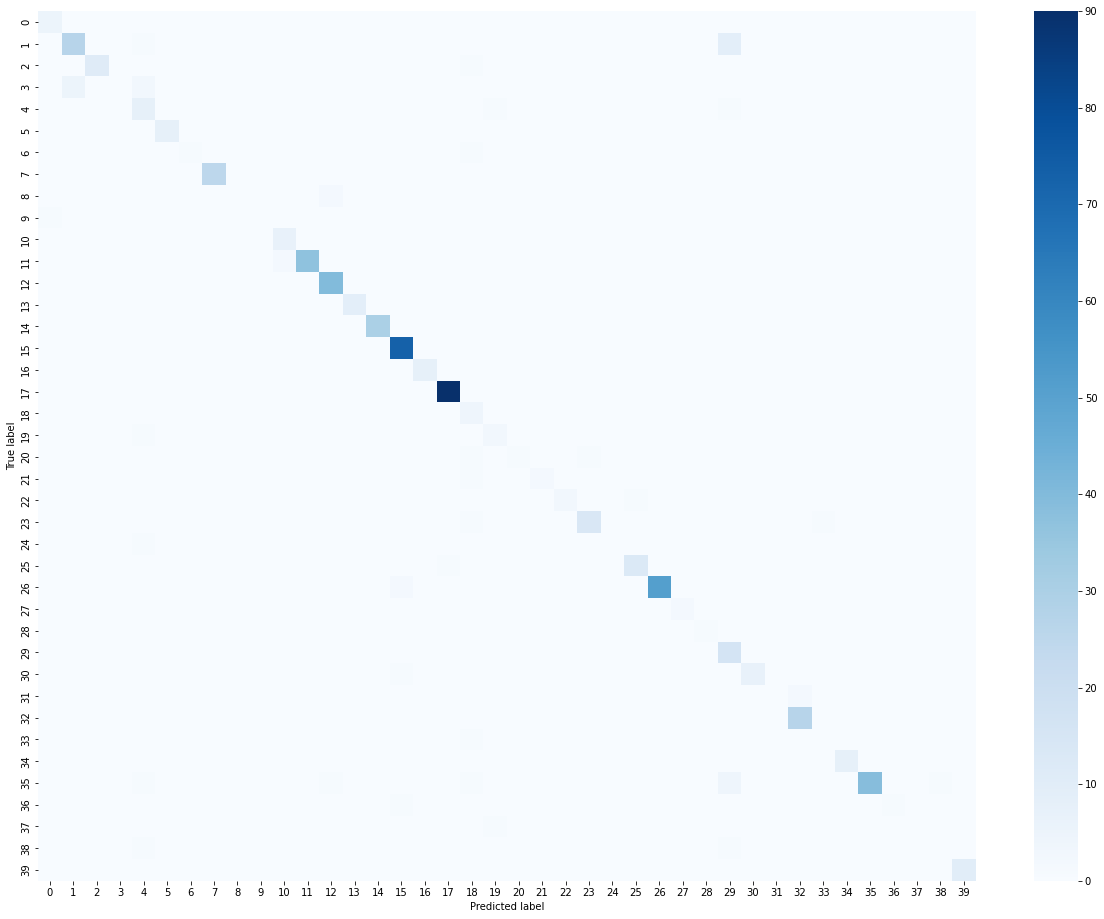

In [24]:
y_pred = [np.argmax(i) for i in modelResNet.predict(test_images_rgb_resnet)]
y_true = np.asarray([np.argmax(i) for i in y_test])

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm)

plt.figure(figsize = (21,16))
ax = sn.heatmap(df_cm, cmap="Blues")
ax.set(xlabel='Predicted label', ylabel='True label')

### Inception v3 model

In [25]:
from tensorflow.keras.applications import InceptionV3

image_shape = (100, 100, 3)
base_model = InceptionV3(include_top=False, input_shape=image_shape, pooling = 'avg', weights = 'imagenet')

modelInception = Sequential()
modelInception.add(base_model)

modelInception.add(Dense(256, activation="relu"))
modelInception.add(Dropout(0.3))
modelInception.add(Dense(128, activation="relu"))
modelInception.add(Dropout(0.3))

modelInception.add(Dense(num_labels, activation = 'softmax'))

In [26]:
modelInception.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
dense_3 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 40)                5160      
Total params: 22,365,384
Trainable params: 22,330,952
Non-trainable params: 34,432
_____________________________________

In [27]:
train_images_rgb_inception = tf.keras.applications.inception_v3.preprocess_input(train_images_rgb)
test_images_rgb_inception = tf.keras.applications.inception_v3.preprocess_input(test_images_rgb)

In [28]:
modelInception.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

train_history = modelInception.fit(
    train_images_rgb_inception, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(test_images_rgb_inception, y_test))

Epoch 1/20
78/78 [==============================] - 26s 328ms/step - loss: 3.6954 - accuracy: 0.1119 - val_loss: 38865284.0000 - val_accuracy: 0.0835
Epoch 2/20
78/78 [==============================] - 18s 236ms/step - loss: 3.0785 - accuracy: 0.1325 - val_loss: 3977.5291 - val_accuracy: 0.0614
Epoch 3/20
78/78 [==============================] - 18s 235ms/step - loss: 3.0578 - accuracy: 0.1390 - val_loss: 3.0974 - val_accuracy: 0.1165
Epoch 4/20
78/78 [==============================] - 19s 239ms/step - loss: 3.0524 - accuracy: 0.1350 - val_loss: 7.7602 - val_accuracy: 0.1150
Epoch 5/20
78/78 [==============================] - 19s 240ms/step - loss: 3.0459 - accuracy: 0.1423 - val_loss: 3.1038 - val_accuracy: 0.1465
Epoch 6/20
78/78 [==============================] - 18s 237ms/step - loss: 3.0307 - accuracy: 0.1463 - val_loss: 3.0417 - val_accuracy: 0.1417
Epoch 7/20
78/78 [==============================] - 18s 236ms/step - loss: 3.0408 - accuracy: 0.1390 - val_loss: 3.0493 - val_accura

In [29]:
scores_inception = modelInception.evaluate(test_images_rgb_inception, y_test)

print("Loss: " + str(scores_inception[0]))
print("Accuracy: " + str(scores_inception[1]))

20/20 [==============================] - 1s 63ms/step - loss: 3.0874 - accuracy: 0.1150
Loss: 3.0873513221740723
Accuracy: 0.11496063321828842


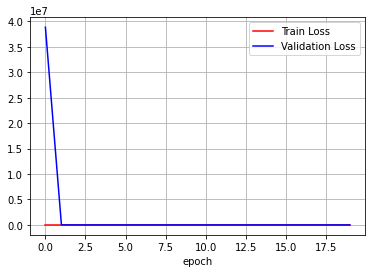

In [30]:
plt.plot(train_history.history['loss'], color='r', label='Train Loss')
plt.plot(train_history.history['val_loss'], color='b', label='Validation Loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()

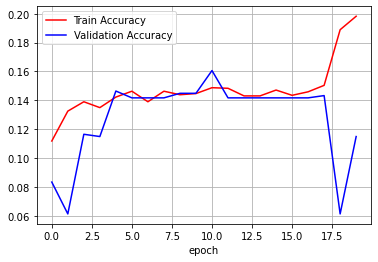

In [31]:
plt.plot(train_history.history['accuracy'], color='r', label='Train Accuracy')
plt.plot(train_history.history['val_accuracy'], color='b', label='Validation Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()

[Text(0.5, 123.0, 'Predicted label'), Text(168.0, 0.5, 'True label')]

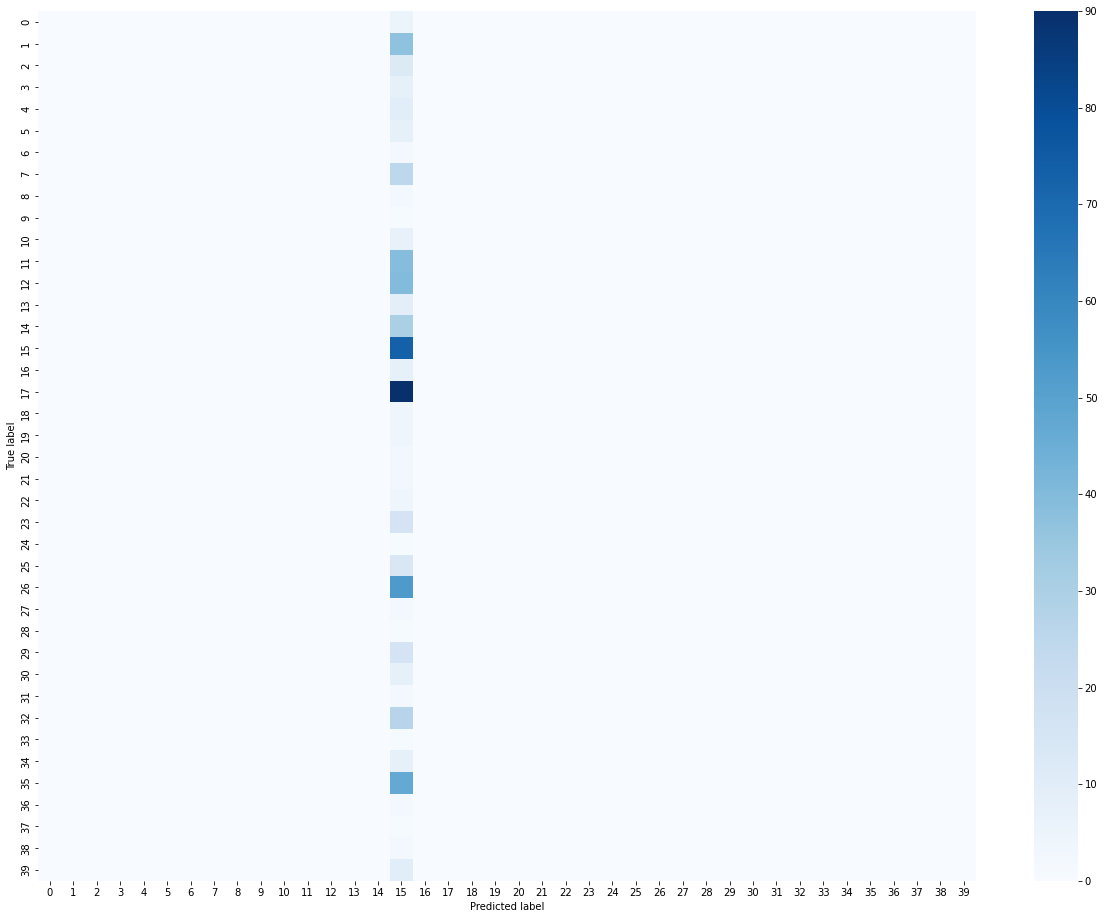

In [32]:
y_pred = [np.argmax(i) for i in modelInception.predict(test_images_rgb_inception)]
y_true = np.asarray([np.argmax(i) for i in y_test])

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm)

plt.figure(figsize = (21,16))
ax = sn.heatmap(df_cm, cmap="Blues")
ax.set(xlabel='Predicted label', ylabel='True label')

### Xception model

In [33]:
from tensorflow.keras.applications import Xception

image_shape = (100, 100, 3)
base_model = Xception(include_top=False, input_shape=image_shape, pooling = 'avg', weights = 'imagenet')

modelXception = Sequential()
modelXception.add(base_model)

modelXception.add(Dense(256, activation="relu"))
modelXception.add(Dropout(0.3))
modelXception.add(Dense(128, activation="relu"))
modelXception.add(Dropout(0.3))

modelXception.add(Dense(num_labels, activation = 'softmax'))

In [34]:
train_images_rgb_xception = tf.keras.applications.xception.preprocess_input(train_images_rgb)
test_images_rgb_xception = tf.keras.applications.xception.preprocess_input(test_images_rgb)

In [35]:
optimizer = Adam(learning_rate=0.001)

In [36]:
modelXception.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

train_history = modelXception.fit(
    train_images_rgb_xception, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(test_images_rgb_xception, y_test))

Epoch 1/20
78/78 [==============================] - 43s 553ms/step - loss: 1.8299 - accuracy: 0.5630 - val_loss: 7.5970 - val_accuracy: 0.4898
Epoch 2/20
78/78 [==============================] - 39s 495ms/step - loss: 0.8596 - accuracy: 0.8014 - val_loss: 1.7953 - val_accuracy: 0.8031
Epoch 3/20
78/78 [==============================] - 40s 515ms/step - loss: 0.6405 - accuracy: 0.8476 - val_loss: 1.3011 - val_accuracy: 0.8425
Epoch 4/20
78/78 [==============================] - 40s 510ms/step - loss: 0.5083 - accuracy: 0.8865 - val_loss: 0.9483 - val_accuracy: 0.8094
Epoch 5/20
78/78 [==============================] - 38s 493ms/step - loss: 0.4952 - accuracy: 0.8788 - val_loss: 0.5212 - val_accuracy: 0.8835
Epoch 6/20
78/78 [==============================] - 39s 504ms/step - loss: 0.2954 - accuracy: 0.9315 - val_loss: 3.7812 - val_accuracy: 0.8142
Epoch 7/20
78/78 [==============================] - 41s 523ms/step - loss: 0.3203 - accuracy: 0.9189 - val_loss: 0.4293 - val_accuracy: 0.9150

In [37]:
scores_xception = modelXception.evaluate(test_images_rgb_xception, y_test)

print("Loss: " + str(scores_xception[0]))
print("Accuracy: " + str(scores_xception[1]))

20/20 [==============================] - 2s 98ms/step - loss: 0.1609 - accuracy: 0.9591
Loss: 0.1609426587820053
Accuracy: 0.9590551257133484


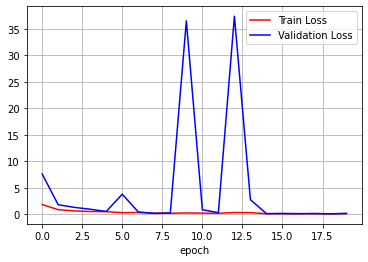

In [38]:
plt.plot(train_history.history['loss'], color='r', label='Train Loss')
plt.plot(train_history.history['val_loss'], color='b', label='Validation Loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()

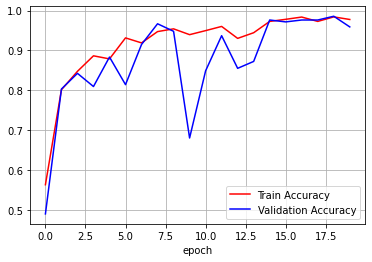

In [39]:
plt.plot(train_history.history['accuracy'], color='r', label='Train Accuracy')
plt.plot(train_history.history['val_accuracy'], color='b', label='Validation Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()

[Text(0.5, 123.0, 'Predicted label'), Text(168.0, 0.5, 'True label')]

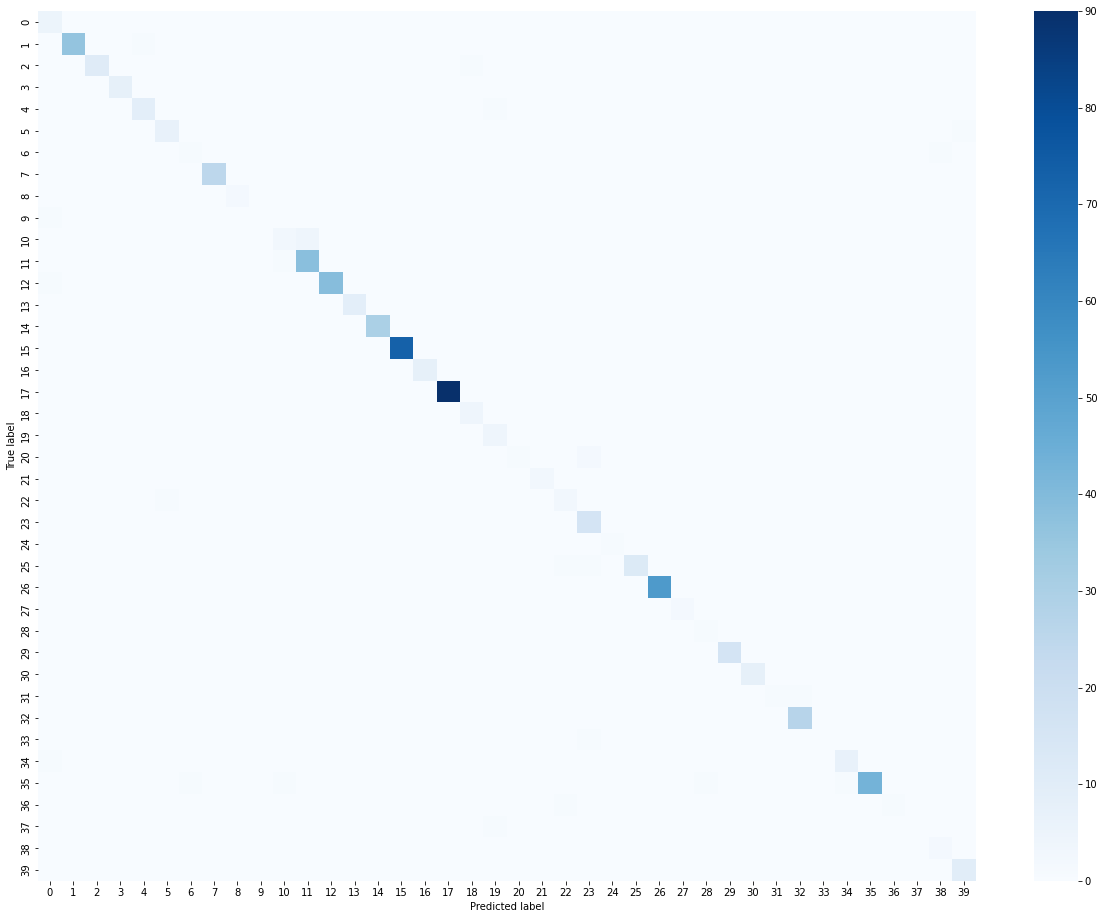

In [40]:
y_pred = [np.argmax(i) for i in modelXception.predict(test_images_rgb_xception)]
y_true = np.asarray([np.argmax(i) for i in y_test])

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm)

plt.figure(figsize = (21,16))
ax = sn.heatmap(df_cm, cmap="Blues")
ax.set(xlabel='Predicted label', ylabel='True label')

### Glyphnet - model architecture proposed in article

In [41]:
model = Sequential()

#first block
model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), input_shape=(100, 100, 1), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Activation('relu'))

#second block
model.add(SeparableConv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(SeparableConv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Activation('relu'))

#third block
model.add(SeparableConv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(SeparableConv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Activation('relu'))

#fourth block
model.add(SeparableConv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(SeparableConv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Activation('relu'))

#fifth block
model.add(SeparableConv2D(512, kernel_size=(3, 3), strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.15))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(num_labels, activation='softmax'))

In [42]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_98 (Conv2D)           (None, 100, 100, 64)      640       
_________________________________________________________________
batch_normalization_98 (Batc (None, 100, 100, 64)      256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 49, 49, 64)        0         
_________________________________________________________________
activation_94 (Activation)   (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 49, 49, 64)        36928     
_________________________________________________________________
batch_normalization_99 (Batc (None, 49, 49, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 64)       

In [43]:
model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=['accuracy'])

run_hist = model.fit(x_train, y_train,
                     epochs=20,
                     validation_data=(x_test, y_test),
                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15)])

Epoch 1/20
78/78 [==============================] - 9s 114ms/step - loss: 2.1297 - accuracy: 0.4378 - val_loss: 3.6068 - val_accuracy: 0.1150
Epoch 2/20
78/78 [==============================] - 8s 98ms/step - loss: 0.9108 - accuracy: 0.7722 - val_loss: 3.5971 - val_accuracy: 0.1150
Epoch 3/20
78/78 [==============================] - 8s 97ms/step - loss: 0.4988 - accuracy: 0.8642 - val_loss: 3.8825 - val_accuracy: 0.0157
Epoch 4/20
78/78 [==============================] - 8s 97ms/step - loss: 0.4723 - accuracy: 0.8727 - val_loss: 4.3603 - val_accuracy: 0.1150
Epoch 5/20
78/78 [==============================] - 8s 97ms/step - loss: 0.3165 - accuracy: 0.9108 - val_loss: 4.8990 - val_accuracy: 0.0126
Epoch 6/20
78/78 [==============================] - 8s 97ms/step - loss: 0.2865 - accuracy: 0.9254 - val_loss: 4.3431 - val_accuracy: 0.0646
Epoch 7/20
78/78 [==============================] - 8s 98ms/step - loss: 0.2261 - accuracy: 0.9339 - val_loss: 1.9961 - val_accuracy: 0.4142
Epoch 8/20
7

In [44]:
scores = model.evaluate(x_test, y_test)

print("Loss: " + str(scores[0]))
print("Accuracy: " + str(scores[1]))

20/20 [==============================] - 1s 30ms/step - loss: 0.4224 - accuracy: 0.8756
Loss: 0.42236000299453735
Accuracy: 0.8755905628204346


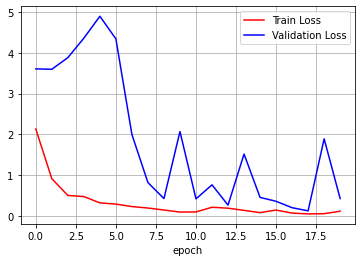

In [45]:
plt.plot(run_hist.history['loss'], color='r', label='Train Loss')
plt.plot(run_hist.history['val_loss'], color='b', label='Validation Loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()

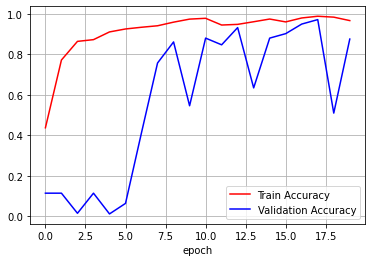

In [46]:
plt.plot(run_hist.history['accuracy'], color='r', label='Train Accuracy')
plt.plot(run_hist.history['val_accuracy'], color='b', label='Validation Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()

[Text(0.5, 123.0, 'Predicted label'), Text(168.0, 0.5, 'True label')]

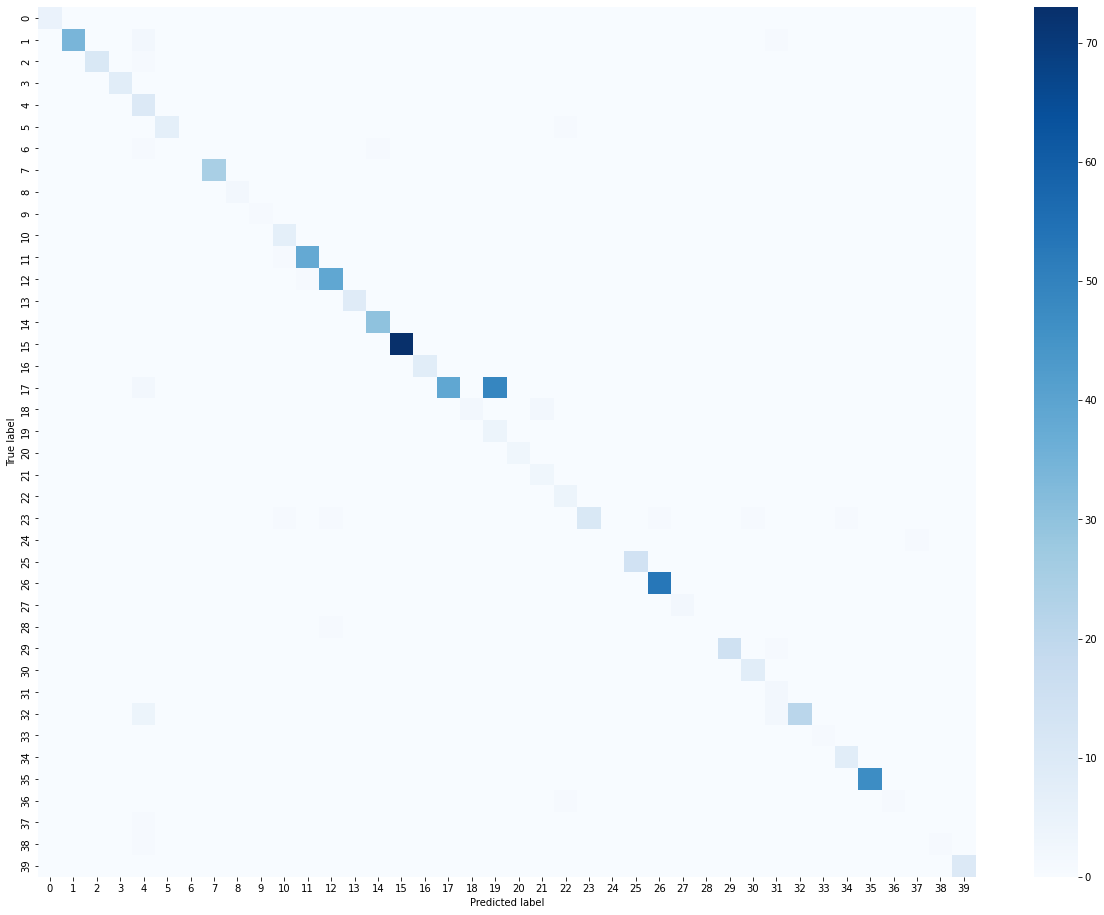

In [47]:
y_pred = [np.argmax(i) for i in model.predict(x_test)]
y_true = np.asarray([np.argmax(i) for i in y_test])

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm)

plt.figure(figsize = (21,16))
ax = sn.heatmap(df_cm, cmap="Blues")
ax.set(xlabel='Predicted label', ylabel='True label')

### Tests on other images

In [48]:
from skimage import color

def readHieroglyphDataExternal(data_dir):
    images = []
    targets = []
    gray = []
    for img in os.listdir(data_dir):
        targets.append(os.path.splitext(img)[0])
        images.append(np.asarray(io.imread(os.path.join(data_dir, img))))
        gray.append(color.rgb2gray(color.rgba2rgb(io.imread(os.path.join(data_dir, img)))))
    return images, targets, gray

In [49]:
external_dir = os.path.join(sys.path[0], 'external/')

ext_imgs, ext_targets, ext_gray = readHieroglyphDataExternal(external_dir)

In [50]:
print(ext_targets)

['D2', 'D46', 'N35', 'O1', 'S34']


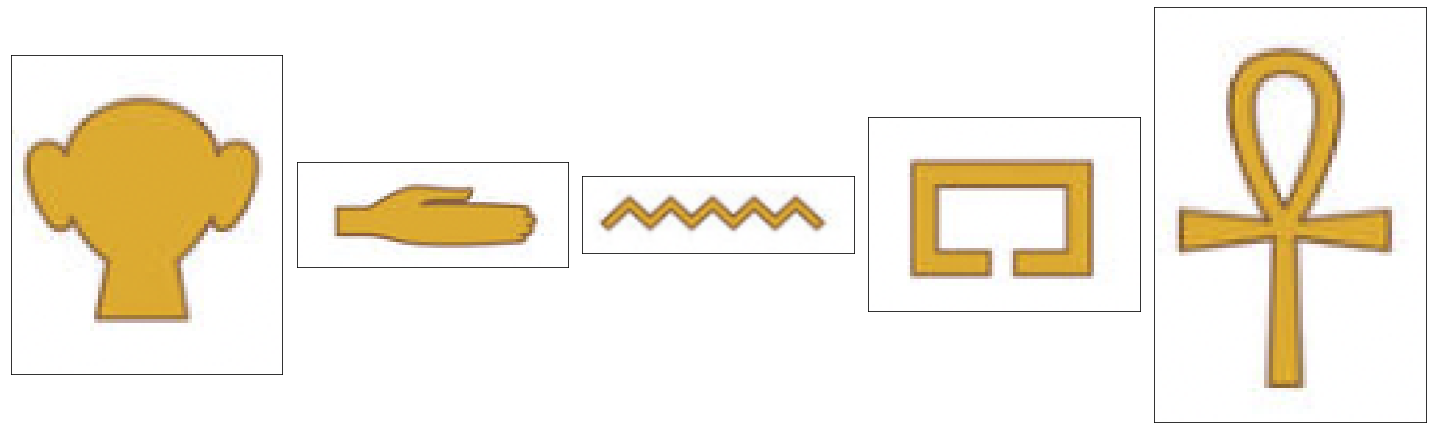

In [51]:
def overview_ext(X):
    fig = plt.figure(figsize=(20,20))
    for i in range(5):
        ax = fig.add_subplot(1, 5, i+1)
        ax.imshow(X[i], cmap='gray')
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
    plt.show()

overview_ext(ext_imgs)

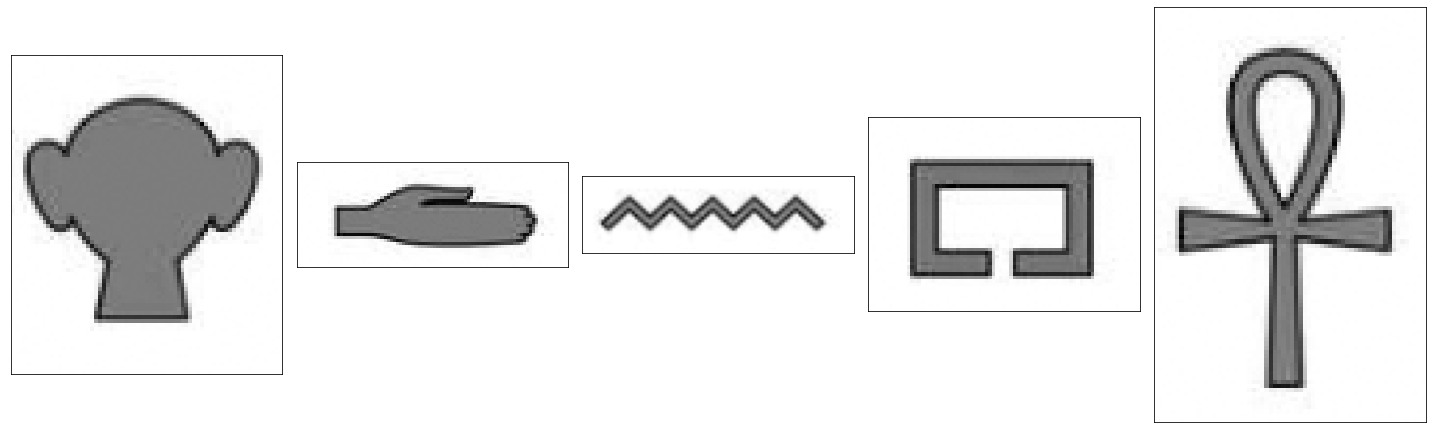

In [52]:
overview_ext(ext_gray)

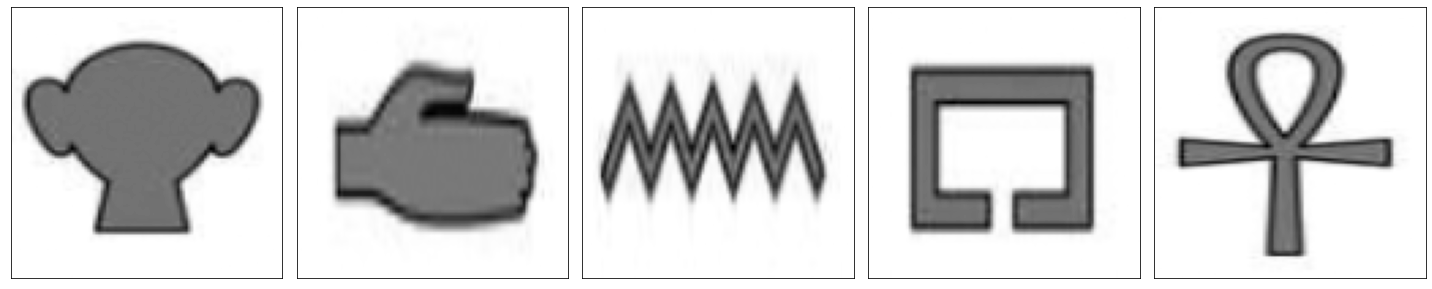

In [53]:
ext_resized = [resize(image, (100, 100), anti_aliasing=True) for image in ext_gray]

overview_ext(ext_resized)

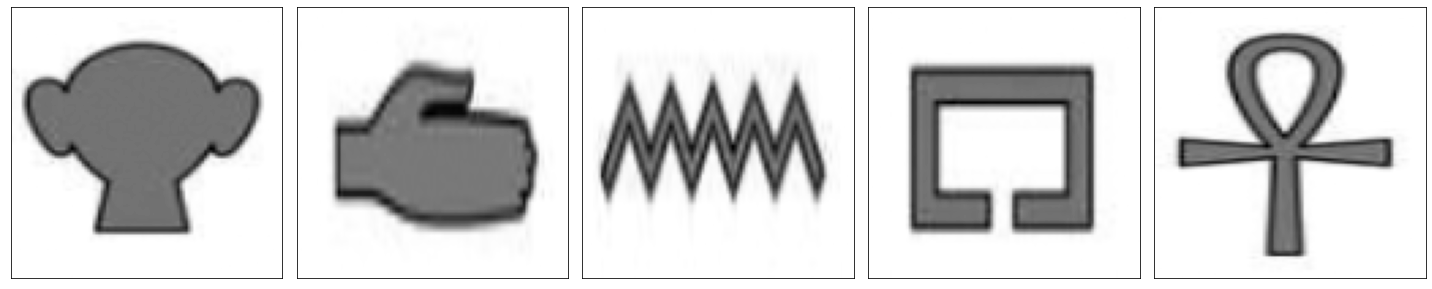

In [54]:
from skimage.transform import resize

ext_resized = [resize(image, (100, 100), anti_aliasing=True) for image in ext_gray]

overview_ext(ext_resized)

In [55]:
pred_ext = [np.argmax(i) for i in model.predict(np.expand_dims(ext_resized, -1))]
pred_ext

[26, 26, 26, 26, 26]

In [56]:
pred_labels = [le.classes_[i] for i in pred_ext]
print("Expected: ", ext_targets)
print("Predicted: ", pred_labels)

Expected:  ['D2', 'D46', 'N35', 'O1', 'S34']
Predicted:  ['S29', 'S29', 'S29', 'S29', 'S29']
